# mHrecoil with FCCSchema

## Configuration

In [1]:
import pandas as pd
##########################
# Define plot properties #
##########################
plot_props = pd.DataFrame({
    'Zm':{'name':'Zm','title':'Z Candidate mass','xlabel':'$Z_{mass}$ [GeV]','ylabel':'Events','bins':100,'xmin':0,'xmax':250},
    'Zm_zoom':{'name':'Zm_zoom','title':'Z Candidate mass','xlabel':'$Z_{mass}$ [GeV]','ylabel':'Events','bins':40,'xmin':80,'xmax':100},
    'Recoilm':{'name':'Recoilm','title':'Leptonic Recoil mass','xlabel':'$Recoil_{mass}$ [GeV]','ylabel':'Events','bins':100,'xmin':0,'xmax':200},
    'Recoilm_zoom':{'name':'Recoilm_zoom','title':'Leptonic Recoil mass','xlabel':'$Recoil_{mass}$ [GeV]','ylabel':'Events','bins':200,'xmin':80,'xmax':160},
    'Recoilm_zoom1':{'name':'Recoilm_zoom1','title':'Leptonic Recoil mass','xlabel':'$Recoil_{mass}$ [GeV]','ylabel':'Events','bins':100,'xmin':120,'xmax':140},
    'Recoilm_zoom2':{'name':'Recoilm_zoom2','title':'Leptonic Recoil mass','xlabel':'$Recoil_{mass}$ [GeV]','ylabel':'Events','bins':200,'xmin':120,'xmax':140},
    'Recoilm_zoom3':{'name':'Recoilm_zoom3','title':'Leptonic Recoil mass','xlabel':'$Recoil_{mass}$ [GeV]','ylabel':'Events','bins':400,'xmin':120,'xmax':140},
    'Recoilm_zoom4':{'name':'Recoilm_zoom4','title':'Leptonic Recoil mass','xlabel':'$Recoil_{mass}$ [GeV]','ylabel':'Events','bins':800,'xmin':120,'xmax':140},
    'Recoilm_zoom5':{'name':'Recoilm_zoom5','title':'Leptonic Recoil mass','xlabel':'$Recoil_{mass}$ [GeV]','ylabel':'Events','bins':2000,'xmin':120,'xmax':140},
    'Recoilm_zoom6':{'name':'Recoilm_zoom6','title':'Leptonic Recoil mass','xlabel':'$Recoil_{mass}$ [GeV]','ylabel':'Events','bins':100,'xmin':130.3,'xmax':140}
})
ecm=240
intLumi = 5.0e+06 #in pb-1

In [2]:
# Why pandas?
# So I can do this:
plot_props.Zm.title #Just looks more clean in my opinion

'Z Candidate mass'

In [10]:
######################
# Define the fileset #
######################
redirector = 'root://eospublic.cern.ch//'
# redirector = ''
''' In case of problems, Download the root files from the following links:
https://prayag.web.cern.ch/share/FCC/eos/experiment/fcc/ee/generation/DelphesEvents/spring2021/IDEA/p8_ee_ZH_ecm240/events_082532938.root
https://prayag.web.cern.ch/share/FCC/eos/experiment/fcc/ee/generation/DelphesEvents/spring2021/IDEA/p8_ee_ZZ_ecm240/events_015472946.root
https://prayag.web.cern.ch/share/FCC/eos/experiment/fcc/ee/generation/DelphesEvents/spring2021/IDEA/p8_ee_WW_ecm240/events_040168535.root
'''
fileset = {
    'ZH':{
        'files':{
            redirector+'eos/experiment/fcc/ee/generation/DelphesEvents/spring2021/IDEA/p8_ee_ZH_ecm240/events_082532938.root':'events'
        },
        'metadata':{
            'dataset':'p8_ee_ZH_ecm240',
            'source':'https://fcc-physics-events.web.cern.ch/fcc-ee/delphes/spring2021/idea/',
            'cross_section':0.201868, # in pb
            'comments':'inclusive decays',
            'label':'ZH',
            'color':'red'
        }
    },
    'ZZ':{
        'files':{
            redirector+'eos/experiment/fcc/ee/generation/DelphesEvents/spring2021/IDEA/p8_ee_ZZ_ecm240/events_015472946.root':'events'
        },
        'metadata':{
            'dataset':'p8_ee_ZZ_ecm240',
            'source':'https://fcc-physics-events.web.cern.ch/fcc-ee/delphes/spring2021/idea/',
            'cross_section':1.35899, # in pb
            'comments':'inclusive decays',
            'label':'ZZ',
            'color':'blue'
        }
    },
    'WW':{
        'files':{
            redirector+'eos/experiment/fcc/ee/generation/DelphesEvents/spring2021/IDEA/p8_ee_WW_ecm240/events_040168535.root':'events'
        },
        'metadata':{
            'dataset':'p8_ee_WW_ecm240',
            'source':'https://fcc-physics-events.web.cern.ch/fcc-ee/delphes/spring2021/idea/',
            'cross_section':16.4385, # in pb
            'comments':'inclusive decays',
            'label':'WW',
            'color':'green'
        }
    }
}

## The processor

In [11]:
from coffea import processor
from coffea.analysis_tools import PackedSelection, Cutflow
import awkward as ak
import dask_awkward as dak
import hist.dask as hda
from collections import namedtuple
import hist
import vector
vector.register_awkward() # Needed to create LorentzVectors with awkward array

### Some helper functions

In [12]:
def get_1Dhist(name, var, flatten=False):
    '''
    name: eg. Zm
    var: eg. variable containing array of mass of Z
    flatten: If to flatten var before fill; False by default
    Returns a histogram
    '''
    props = plot_props[name]
    if flatten : var = dak.ravel(var) # Removes None values and all the nesting
    var = var[~dak.is_none(var, axis=0)] # Remove None values only
    return hda.Hist.new.Reg(props.bins, props.xmin, props.xmax).Double().fill(var)


def Reso_builder(lepton, resonance):
    '''
    Builds Resonance candidates
    Input:    lepton(var*[var*LorentzVector]),
              resonance(float)
    Output: Reso([var*LorentzVecctor]) best resonance candidate in each event (maximum one per event)
    '''
    #Create all the combinations
    combs = dak.combinations(lepton,2)
    # Get dileptons
    lep1 , lep2 = dak.unzip(combs)
    di_lep = lep1 + lep2 # This process drops any other field except 4 momentum fields

    di_lep["q"] = lep1.charge + lep2.charge

    # Sort by closest mass to the resonance value
    sort_mask = dak.argsort(abs(resonance-di_lep.mass), axis=1)
    Reso = di_lep[sort_mask]

    #Choose the best candidate
    Reso = dak.fill_none(Reso,[],axis=0) #Transform the None values at axis 0 to [], so that they survive the next operation
    Reso = dak.firsts(Reso) #Chooses the first elements and flattens out, [] gets converted to None

    return Reso

### The processor definition

In [13]:
class mHrecoil(processor.ProcessorABC):
    '''
    mHrecoil example: e^+ + e^- rightarrow ZH rightarrow mu^+ mu^- + X(Recoil)
    Note: Use only BaseSchema with this processor
    '''
    def __init__(self, ecm):
        self.arg_ecm = ecm #\sqrt(s) in GeV
        self.arg_zmass = 91.0 #GeV

    def process(self,events):

        #Create a Packed Selection object to get a cutflow later
        cut = PackedSelection()
        cut.add('No cut', dak.num(events.ReconstructedParticles.E) > 0)

        # Filter out any event with no reconstructed particles and generate Reconstructed Particle Attributes
        #ak.mask preserves array length
        at_least_one_recon = dak.num(events.ReconstructedParticles.E, axis=1) > 0
        good_events = dak.mask(events,at_least_one_recon)
        cut.add('At least one Reco Particle', at_least_one_recon)

        Reco = good_events.ReconstructedParticles
        Muon = Reco[good_events.Muonidx0.index]

        # Create Array of Muon Lorentz Vector
        # Muon = ak.zip({"px":Muons.momentum_x,"py":Muons.momentum_y,"pz":Muons.momentum_z,"E":Muons.energy,"q":Muons.charge,}, with_name="Momentum4D")

        # Get Muons with a pt cut , if none of the muons in an event pass the cut, return none, ensuring the size of the cutflow
        pt_mask = dak.any(Muon.pt > 10, axis = 1)
        temp = dak.mask(Muon, pt_mask)
        Muon = Muon[temp.pt > 10]
        cut.add('At least one Muon pt > 10', pt_mask)

        # Get best Resonance around Z mass in https://youtu.be/eGcVFJ7esEY?si=TyG3XJwlkShLDpcgan event
        Z_cand = Reso_builder(Muon, self.arg_zmass)

        # Selection 0 : Z q=0 candidate
        q_mask = (Z_cand.q == 0)
        Z_cand_sel0 = dak.mask(Z_cand, q_mask)
        cut.add("Z_q = 0", q_mask)
        sel0_ocl = cut.cutflow(*cut.names).yieldhist()

        # Selection 1 : 80 < M_Z < 100
        Z_mass_mask = (Z_cand.mass > 80.0) & (Z_cand.mass < 100.0)
        Z_cand_sel1 = ak.mask(Z_cand, Z_mass_mask)
        cut.add('80 < $M_Z$ < 100',Z_mass_mask)
        sel = [*cut.names]
        sel.remove(sel[-2])
        sel1_ocl = cut.cutflow(*sel).yieldhist()

        #Recoil Calculation
        Recoil_sel0 = ak.zip({"px":0.0-Z_cand_sel0.px,"py":0.0-Z_cand_sel0.py,"pz":0.0-Z_cand_sel0.pz,"E":self.arg_ecm-Z_cand_sel0.E},with_name="Momentum4D")
        Recoil_sel1 = ak.zip({"px":0.0-Z_cand_sel1.px,"py":0.0-Z_cand_sel1.py,"pz":0.0-Z_cand_sel1.pz,"E":self.arg_ecm-Z_cand_sel1.E},with_name="Momentum4D")

        #Prepare output
        #Choose the required histograms and their assigned variables to fill
        names = plot_props.columns.to_list()
        vars_sel0 = ([Z_cand_sel0.mass]*2) + ([Recoil_sel0.mass]*8)
        vars_sel1 = ([Z_cand_sel1.mass]*2) + ([Recoil_sel1.mass]*8)
        Output = {
            'histograms': {
                'sel0':{name:get_1Dhist(name,var) for name,var in zip(names,vars_sel0)},
                'sel1':{name:get_1Dhist(name,var) for name,var in zip(names,vars_sel1)}
            },
            'cutflow': {
                'sel0': {'Onecut':sel0_ocl[0],'Cutflow':sel0_ocl[1],'Labels':sel0_ocl[2]},
                'sel1': {'Onecut':sel1_ocl[0],'Cutflow':sel1_ocl[1],'Labels':sel1_ocl[2]}
            },
            'metadata':events.metadata
        }
        return Output

    def postprocess(self, accumulator):
        pass

## Run the processor

In [14]:
from coffea import util
from coffea.nanoevents import FCC
from coffea.dataset_tools import apply_to_fileset,max_chunks,preprocess
import dask
from dask.diagnostics import ProgressBar

In [19]:
# Preprocess the fileset
dataset_runnable, dataset_updated = preprocess(
    fileset,
    align_clusters=False,
    step_size=5_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

In [20]:
from coffea import __version__ as coffea_version

(v1, v2, v3) = coffea_version.split('.') 
using_version = (int(v1), int(v2), int(v3))


fcc_schema = None
if using_version[0] >= 2025:
    if using_version[1] <= 3:
        fcc_schema = FCC.get_schema("latest")
    else:
        raise BaseException(f"FCC schema not yet released for coffea version {using_version}")
elif using_version[1] == 2024:
    if using_version[2] >= 10:
        fcc_schema = FCC.get_schema("latest")
    else:
        raise BaseException(f"FCC schema not supported for coffea version {using_version}")
else:
    raise BaseException(f"FCC schema not supported for coffea version {using_version}")

    
fcc_schema

coffea.nanoevents.schemas.fcc.FCCSchema

In [21]:
# Build the dask taskgraph
to_compute = apply_to_fileset(
        mHrecoil(ecm=ecm),
        dataset_runnable,
        schemaclass=fcc_schema,
    )

In [22]:
# Process
pgb = ProgressBar()
with pgb:
    (out,) = dask.compute(to_compute)

[########################################] | 100% Completed | 520.92 ms
[########################################] | 100% Completed | 66.23 s


## Plots

In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import mplhep as hep
import numpy as np
import os

In [24]:
def get_xsec_scale(dataset, selection, Luminosity):
    '''
    Get final scale factor from cross section
    '''
    xsec = out[dataset]['metadata']['cross_section'] #in picobarn
    raw_events = out[dataset]['cutflow'][selection]['Cutflow'].values()[0]
    if raw_events > 0:
        sf = (xsec*Luminosity)/raw_events
    else :
        raise ValueError('Raw events less than of equal to zero!')
    return round(float(sf),3)

In [25]:
def makeplot(fig, ax, hist, name, title, label, xlabel, ylabel, bins, xmin, xmax, log, stack, color, histtype, xticks=10, cutflow_mode=False, **kwargs):
    '''
    Makes a single kinematic plot on an ax object
    '''
    hep.histplot(
        hist,
        yerr=0,
        histtype=histtype,
        label=label,
        color=color,
        alpha=0.8,
        stack=stack,
        linewidth=1,
        sort='yield_r',
        ax=ax,
        **kwargs
    )

    ax.text(0.27, 1.02, 'FCC Analyses: FCC-ee Simulation (Delphes)', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.92, 1.02, f'$\\sqrt{{s}} = {ecm} GeV$', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    if  cutflow_mode:
        ax.set_ylabel(ylabel)
    else:
        per_bin = '/'+str((xmax-xmin)/bins)
        ax.set_ylabel(ylabel+per_bin+' [GeV]')
        plt.xlim([xmin,xmax])
        plt.xticks(np.linspace(xmin,xmax,xticks+1))
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.set_xlabel(xlabel)

    if log :
        ax.set_yscale('log')
        plt.tick_params(axis='y', which='minor')
    else:
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.set_title(title,pad=25,  fontsize= "15", color="#192655")

In [26]:
def plot(hists, selections, save_path, signal=[], background=[]):
    if len(signal) + len(background) == 0:
        raise FileNotFoundError('Neither Signal, nor Background found!\n Aborting ...')
    for which_selection in selections:
        for which_hist in hists:
        
            fig, ax = plt.subplots(figsize=(8,8))
            
            # Plot Backgrounds first
            if len(background) > 0:
                scaled_hists_background = [
                    out[key]['histograms'][which_selection][which_hist]*get_xsec_scale(key,which_selection,intLumi)
                    for key in out.keys()
                    if key in background
                ]
    
                labels_background = [
                    out[key]['metadata']['label'] 
                    for key in out.keys()
                    if key in background
                ]
    
                colors_background = [
                    out[key]['metadata']['color'] 
                    for key in out.keys()
                    if key in background
                ]
    
                makeplot(
                    fig,
                    ax,
                    scaled_hists_background,
                    **plot_props[which_hist].to_dict(),
                    label=labels_background,
                    log=False,
                    stack=True,
                    color=colors_background,
                    histtype='fill',
                    edgecolor='black'
                )
            if len(signal) > 0 :
                scaled_hists_signal = [
                    out[key]['histograms'][which_selection][which_hist]*get_xsec_scale(key,which_selection,intLumi)
                    for key in out.keys()
                    if key in signal
                ]
    
                labels_signal = [
                    out[key]['metadata']['label'] 
                    for key in out.keys()
                    if key in signal
                ]
    
                colors_signal = [
                    out[key]['metadata']['color'] 
                    for key in out.keys()
                    if key in signal
                ]

                signal_on_top_of_all_backgrounds = [h+sum(scaled_hists_background) for h in scaled_hists_signal] #Manual stacking because independent stacking is not supported in mplhep
    
                makeplot(
                    fig,
                    ax,
                    signal_on_top_of_all_backgrounds,
                    **plot_props[which_hist].to_dict(),
                    label=labels_signal,
                    log=False,
                    stack=False,
                    color=colors_signal,
                    histtype='step'
                )
            # Then plot signal so that it sits on top of the background
            ax.legend();
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            fig.savefig(save_path+'/'+which_selection+'_'+which_hist+'.png', dpi=240)

In [27]:
# Can declare a subset of histograms that we need
Required_hists = ['Zm','Zm_zoom','Recoilm','Recoilm_zoom']
Required_selections = ['sel0', 'sel1']
signal = ['ZH']
background = ['ZZ', 'WW']
save_path = 'output_mHrecoil_with_FCCSchema'

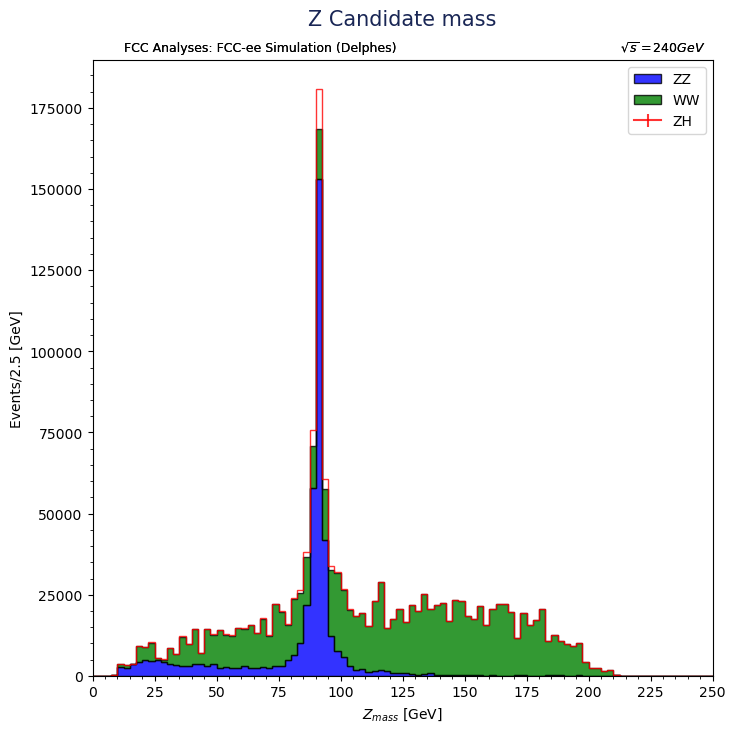

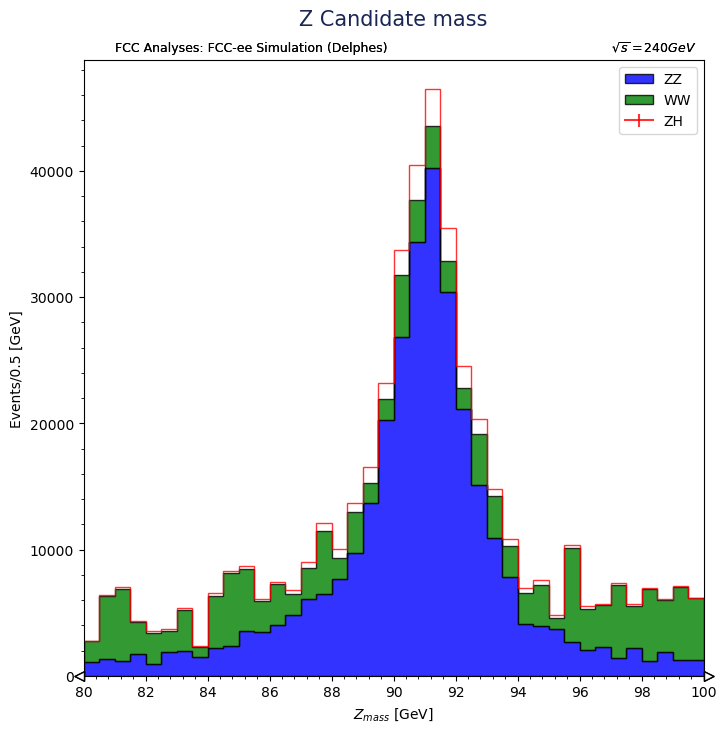

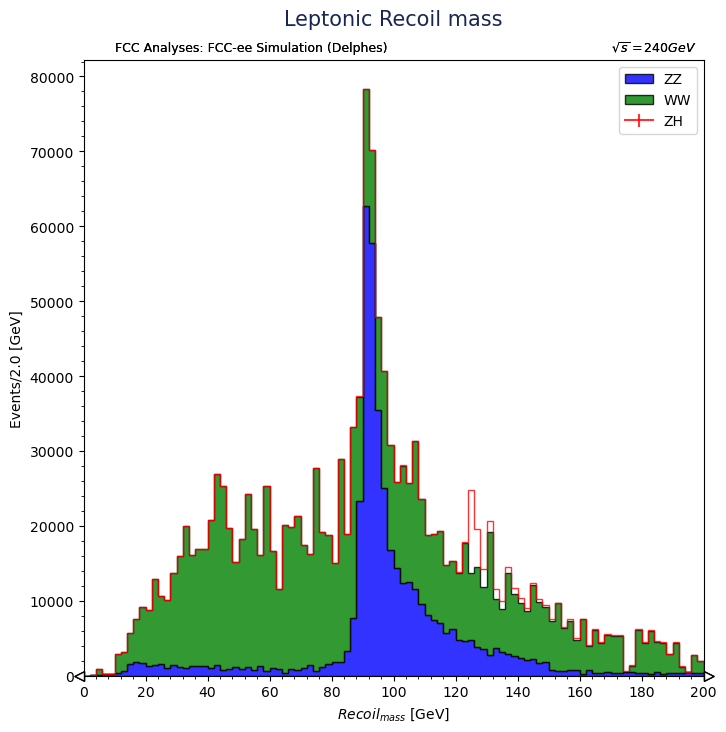

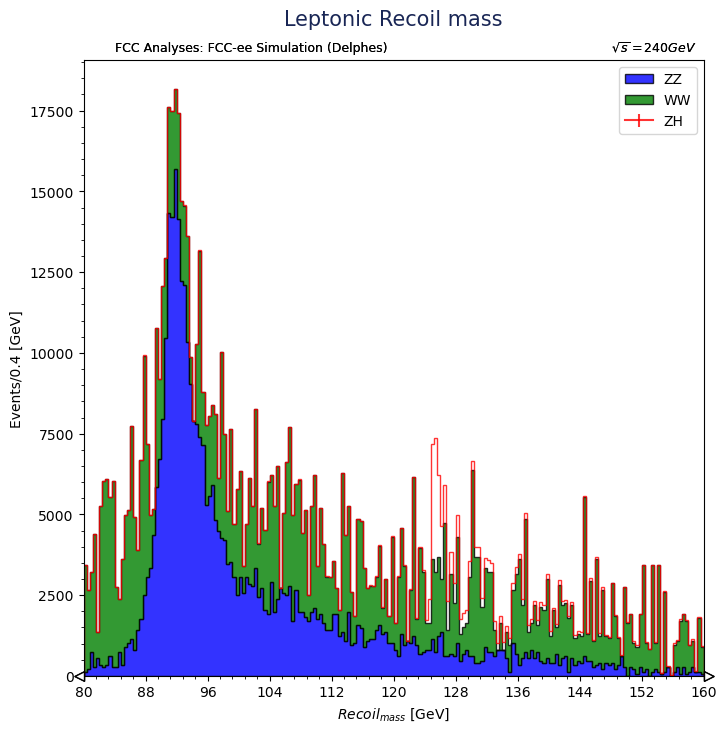

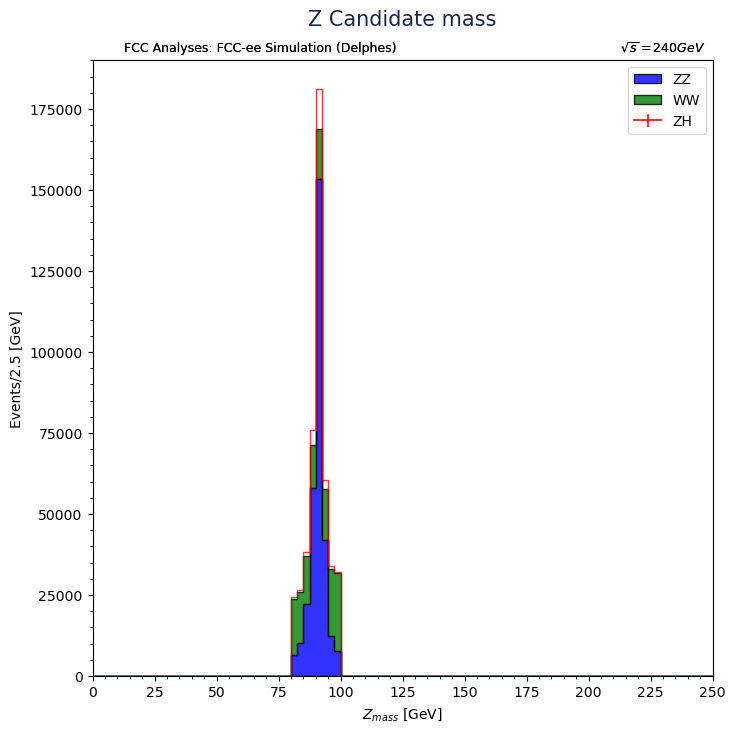

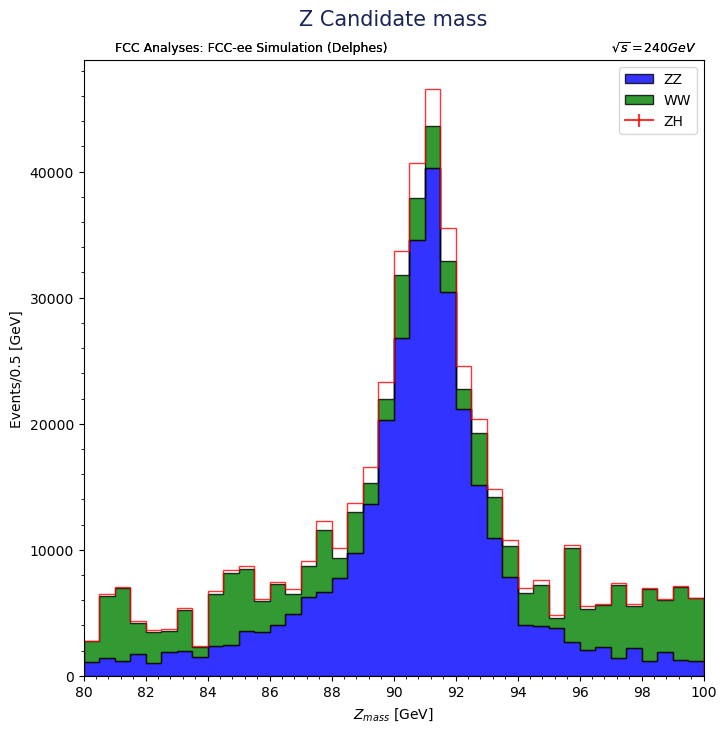

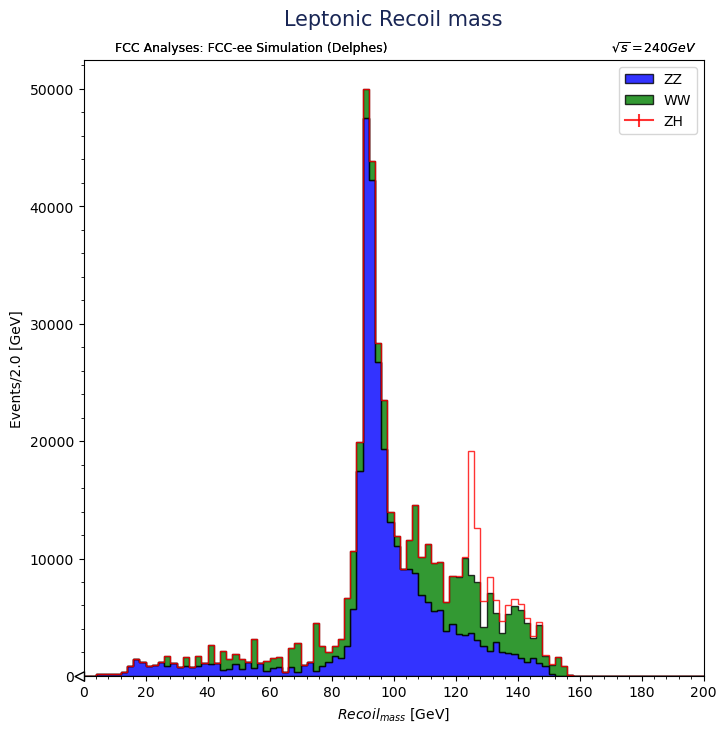

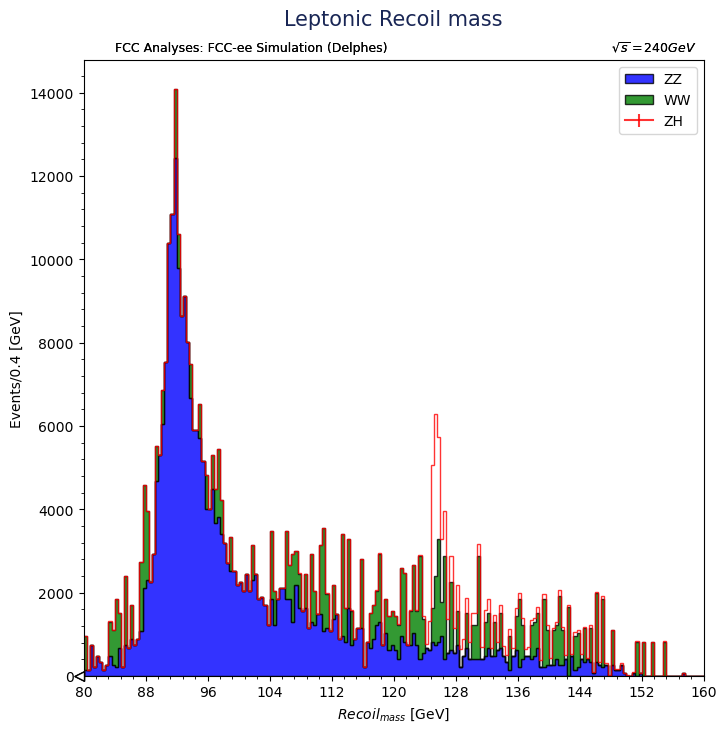

In [28]:
plot(Required_hists, Required_selections, save_path, signal, background)